In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithZScore, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/downsampled_df_random.csv')
data.head()

,userId,wine,rate
0,976ec198-048f-405c-b6e6-b17ee1db1139,Nebbiolo d alba superiore,4
1,4eb7031c-da00-48f4-bc7f-0a1f1eda7cab,Malvasia legno,3
2,13016d41-00bd-411c-83f5-2b95691696b7,Bianco,3
3,13016d41-00bd-411c-83f5-2b95691696b7,Cabernet Franc,3
4,0a23a07a-8556-4ef6-85ee-d996f8ed619e,Talò Primitivo - Merlot,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithZSore (KNNWithZScore):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithZScore.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithZScore.fit(self, trainset_fold)
            train_prediction = KNNWithZScore.test(self, trainset_fold.build_testset())
            prediction = KNNWithZScore.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithZScore.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithZScore SGD

* knn_with_zscore cosine, user based

In [4]:
knn_with_zscore = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore.create_reader(data)
predictions = knn_with_zscore.fit()
#acc
metrics = knn_with_zscore.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2288
RMSE: 1.0292
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2264
RMSE: 1.0421
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2722
RMSE: 0.8910
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2917
RMSE: 0.9374
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2611
RMSE: 0.8144
###############################################
The Results are: 

Average RMSE on Training Set: 0.2560580834136096
Average RMSE on Test Set: 0.9428169201566261
RMSE: 0.9405
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.940483535672087
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9405
MAE:  0.7568
MSE: 0.8845
Precision: 0.66
Recall: 0.70
the acc is 47.90


/tmp/ipykernel_18864/1944145904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [5]:
knn_with_zscore2 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore2.create_reader(data)
predictions = knn_with_zscore2.fit()
#acc
metrics = knn_with_zscore2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2994
RMSE: 0.9835
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2682
RMSE: 0.9659
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2860
RMSE: 0.9542
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3110
RMSE: 0.8054
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2580
RMSE: 0.9467
###############################################
The Results are: 

Average RMSE on Training Set: 0.28453488547912775
Average RMSE on Test Set: 0.9311411228590494
RMSE: 1.0524
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0524445446794384
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0524
MAE:  0.8497
MSE: 1.1076
Precision: 0.56
Recall: 0.63
the acc is 37.82


/tmp/ipykernel_18864/2949601189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2949601189.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [6]:
knn_with_zscore3 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore3.create_reader(data)
predictions = knn_with_zscore3.fit()
#acc
metrics = knn_with_zscore3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2312
RMSE: 0.9527
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2313
RMSE: 0.8343
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2077
RMSE: 1.0569
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1852
RMSE: 1.0084
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2564
RMSE: 0.8679
###############################################
The Results are: 

Average RMSE on Training Set: 0.22236164223689645
Average RMSE on Test Set: 0.9440670923396125
RMSE: 1.0137
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.013692998618298
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0137
MAE:  0.8502
MSE: 1.0276
Precision: 0.69
Recall: 0.76
the acc is 36.13


/tmp/ipykernel_18864/2711717971.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2711717971.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared diference, item based

In [7]:
knn_with_zscore4 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore4.create_reader(data)
predictions = knn_with_zscore4.fit()
#acc
metrics = knn_with_zscore4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2278
RMSE: 1.0568
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2554
RMSE: 1.0794
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2660
RMSE: 0.8682
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2630
RMSE: 0.9730
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2494
RMSE: 0.9203
###############################################
The Results are: 

Average RMSE on Training Set: 0.2522896829145823
Average RMSE on Test Set: 0.9795536687494144
RMSE: 0.9942
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9942259222432365
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9942
MAE:  0.7850
MSE: 0.9885
Precision: 0.63
Recall: 0.72
the acc is 40.34


/tmp/ipykernel_18864/2579909233.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2579909233.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson, user based

In [8]:
knn_with_zscore5 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore5.create_reader(data)
predictions = knn_with_zscore5.fit()
#acc
metrics = knn_with_zscore5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1184
RMSE: 0.7852
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1309
RMSE: 0.8112
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1286
RMSE: 0.9494
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1297
RMSE: 1.0061
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1286
RMSE: 1.0334
###############################################
The Results are: 

Average RMSE on Training Set: 0.12720610830902448
Average RMSE on Test Set: 0.917041163644652
RMSE: 1.0031
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0031032830977338
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0031
MAE:  0.8224
MSE: 1.0062
Precision: 0.58
Recall: 0.67
the acc is 34.45


/tmp/ipykernel_18864/2335934697.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2335934697.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_zscore6 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore6.create_reader(data)
predictions = knn_with_zscore6.fit()
#acc
metrics = knn_with_zscore6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0721
RMSE: 1.0418
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1588
RMSE: 0.9856
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0860
RMSE: 0.9390


/tmp/ipykernel_18864/3850417117.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/3850417117.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1516
RMSE: 0.9057
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1272
RMSE: 0.9237
###############################################
The Results are: 

Average RMSE on Training Set: 0.11915405218308164
Average RMSE on Test Set: 0.9591686363540018
RMSE: 1.1342
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1342452831666117
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1342
MAE:  0.9402
MSE: 1.2865
Precision: 0.58
Recall: 0.65
the acc is 27.73


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_zscore7 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore7.create_reader(data)
predictions = knn_with_zscore7.fit()
#acc
metrics = knn_with_zscore7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1257
RMSE: 1.0074
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1572
RMSE: 0.9726
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1442
RMSE: 0.8810
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1620
RMSE: 0.9241
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0810
RMSE: 0.9540
###############################################
The Results are: 

Average RMSE on Training Set: 0.1340219960094189
Average RMSE on Test Set: 0.9478315946265612
RMSE: 0.9876
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9875767500674714
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18864/2496457707.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2496457707.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_zscore8 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore8.create_reader(data)
predictions = knn_with_zscore8.fit()
#acc
metrics = knn_with_zscore8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0679
RMSE: 0.9346
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0947
RMSE: 0.8300
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0797
RMSE: 0.9946
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0554
RMSE: 0.9961
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0863
RMSE: 0.8771
###############################################
The Results are: 

Average RMSE on Training Set: 0.07679015916309381
Average RMSE on Test Set: 0.9264830937753045
RMSE: 1.0407
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0407113049060497
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18864/1008673265.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/1008673265.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithZScore Alternating Least Squares (ALS)

* knn_with_zscore cosine, user based

In [12]:
knn_with_zscore9 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore9.create_reader(data)
predictions = knn_with_zscore9.fit()
#acc
metrics = knn_with_zscore9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3073
RMSE: 0.9041
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2955
RMSE: 0.8462
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2992
RMSE: 0.8292
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2493
RMSE: 0.9445
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2301
RMSE: 0.9889
###############################################
The Results are: 

Average RMSE on Training Set: 0.2762852631157322
Average RMSE on Test Set: 0.9025733775077163
RMSE: 1.0430
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0430019227521237
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0430
MAE:  0.8411
MSE: 1.0879
Precision: 0.57
Recall: 0.65
the acc is 35.29


/tmp/ipykernel_18864/2936597747.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2936597747.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [13]:
knn_with_zscore10 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore10.create_reader(data)
predictions = knn_with_zscore10.fit()
#acc
metrics = knn_with_zscore10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2495
RMSE: 0.9381
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2565
RMSE: 0.9943
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2259
RMSE: 0.9476
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2560
RMSE: 0.8872
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2502
RMSE: 0.8750
###############################################
The Results are: 

Average RMSE on Training Set: 0.2476171020325329
Average RMSE on Test Set: 0.9284569685938635
RMSE: 1.0851
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0850823345110927
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0851
MAE:  0.8581
MSE: 1.1774
Precision: 0.60
Recall: 0.68
the acc is 37.82


/tmp/ipykernel_18864/1654456447.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/1654456447.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [14]:
knn_with_zscore11 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore11.create_reader(data)
predictions = knn_with_zscore11.fit()
#acc
metrics = knn_with_zscore11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2512
RMSE: 0.9434
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2704
RMSE: 1.0172
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2221
RMSE: 0.9895
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2567
RMSE: 0.9693
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2054
RMSE: 1.0308
###############################################
The Results are: 

Average RMSE on Training Set: 0.24114928788702178
Average RMSE on Test Set: 0.9900452019279473
RMSE: 0.9254
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9254110338943952
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9254
MAE:  0.7763
MSE: 0.8564
Precision: 0.62
Recall: 0.68
the acc is 41.18


/tmp/ipykernel_18864/2380454897.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2380454897.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, item based

In [15]:
knn_with_zscore12 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore12.create_reader(data)
predictions = knn_with_zscore12.fit()
#acc
metrics = knn_with_zscore12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2993
RMSE: 0.8553
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2395
RMSE: 0.9898
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3027
RMSE: 1.0388
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2717
RMSE: 1.0275
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2666
RMSE: 0.8904
###############################################
The Results are: 

Average RMSE on Training Set: 0.27596506626996
Average RMSE on Test Set: 0.9603493689151319
RMSE: 1.0033
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0032781759018599
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0033
MAE:  0.8114
MSE: 1.0066
Precision: 0.67
Recall: 0.71
the acc is 37.82


/tmp/ipykernel_18864/3404645186.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/3404645186.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, user based

In [16]:
knn_with_zscore13 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore13.create_reader(data)
predictions = knn_with_zscore13.fit()
#acc
metrics = knn_with_zscore13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1935
RMSE: 0.9504
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1563
RMSE: 0.9979
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1849
RMSE: 0.8398
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1938
RMSE: 0.9046
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1294
RMSE: 1.0707
###############################################
The Results are: 

Average RMSE on Training Set: 0.1715769685208093
Average RMSE on Test Set: 0.9526926634662802
RMSE: 0.9745
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9744504183611062
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9745
MAE:  0.8211
MSE: 0.9496
Precision: 0.62
Recall: 0.69
the acc is 38.66


/tmp/ipykernel_18864/1814740321.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/1814740321.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, item based

In [17]:
knn_with_zscore14 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore14.create_reader(data)
predictions = knn_with_zscore14.fit()
#acc
metrics = knn_with_zscore14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2160
RMSE: 0.8978
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1200
RMSE: 1.1643
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2033
RMSE: 0.9398


/tmp/ipykernel_18864/1740756307.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/1740756307.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2338
RMSE: 0.8544
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1116
RMSE: 1.0252
###############################################
The Results are: 

Average RMSE on Training Set: 0.17694061321165216
Average RMSE on Test Set: 0.9762896885019643
RMSE: 0.9507
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9507471829985275
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9507
MAE:  0.7745
MSE: 0.9039
Precision: 0.62
Recall: 0.69
the acc is 42.86


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_zscore15 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore15.create_reader(data)
predictions = knn_with_zscore15.fit()
#acc
metrics = knn_with_zscore15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1397
RMSE: 0.9664
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0513
RMSE: 0.9187
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1323
RMSE: 0.8660
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1442
RMSE: 1.0474
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1372
RMSE: 0.8654
###############################################
The Results are: 

Average RMSE on Training Set: 0.12093879186404392
Average RMSE on Test Set: 0.9328067780182051
RMSE: 0.9798
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9797611669199527
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18864/2066309904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/2066309904.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_zscore16 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore16.create_reader(data)
predictions = knn_with_zscore16.fit()
#acc
metrics = knn_with_zscore16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1682
RMSE: 0.9328
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1047
RMSE: 1.0047
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1756
RMSE: 1.0618
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0630
RMSE: 0.9178
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1757
RMSE: 0.8188
###############################################
The Results are: 

Average RMSE on Training Set: 0.13742975658179912
Average RMSE on Test Set: 0.9471971019308079
RMSE: 1.0382
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0381725508682398
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18864/3669178657.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18864/3669178657.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
10,11,KnnWithZSore,MSD,ALS,True,0.925411,0.776309,0.856386,0.621324,0.681373,41.176471
0,1,KnnWithZSore,Cosine,SGD,True,0.940484,0.756842,0.884509,0.663661,0.698087,47.899160
13,14,KnnWithZSore,pearson corr coeff,ALS,False,0.950747,0.774531,0.903920,0.616898,0.694444,42.857143
12,13,KnnWithZSore,pearson corr coeff,ALS,True,0.974450,0.821062,0.949554,0.624914,0.692029,38.655462
14,15,KnnWithZSore,(shrunk) pearson corr coeff,ALS,True,0.979761,0.768341,0.959932,0.589552,0.671642,43.697479
6,7,KnnWithZSore,(shrunk) pearson corr coeff,SGD,True,0.987577,0.773680,0.975308,0.596948,0.671362,38.655462
3,4,KnnWithZSore,MSD,SGD,False,0.994226,0.784998,0.988485,0.632857,0.715385,40.336134
4,5,KnnWithZSore,pearson corr coeff,SGD,True,1.003103,0.822352,1.006216,0.579524,0.671429,34.453782
11,12,KnnWithZSore,MSD,ALS,False,1.003278,0.811388,1.006567,0.668860,0.714912,37.815126
2,3,KnnWithZSore,MSD,SGD,True,1.013693,0.850150,1.027573,0.687401,0.756944,36.134454


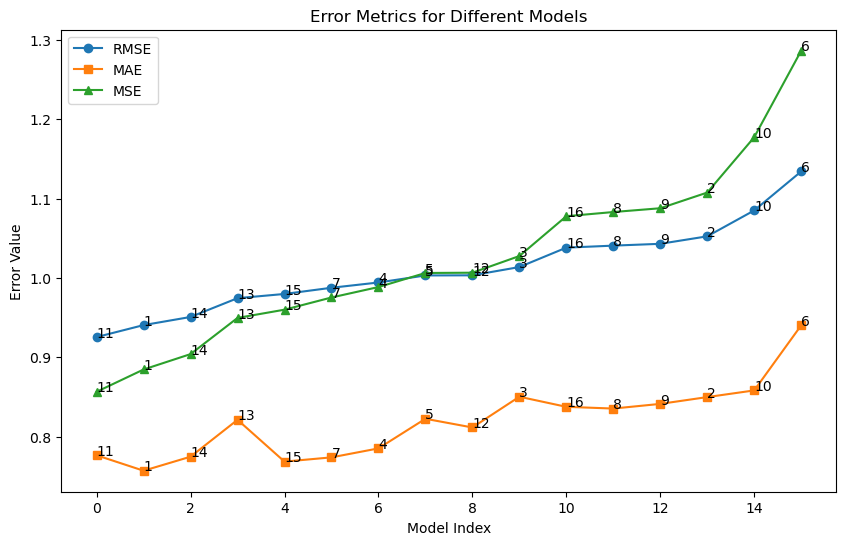

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

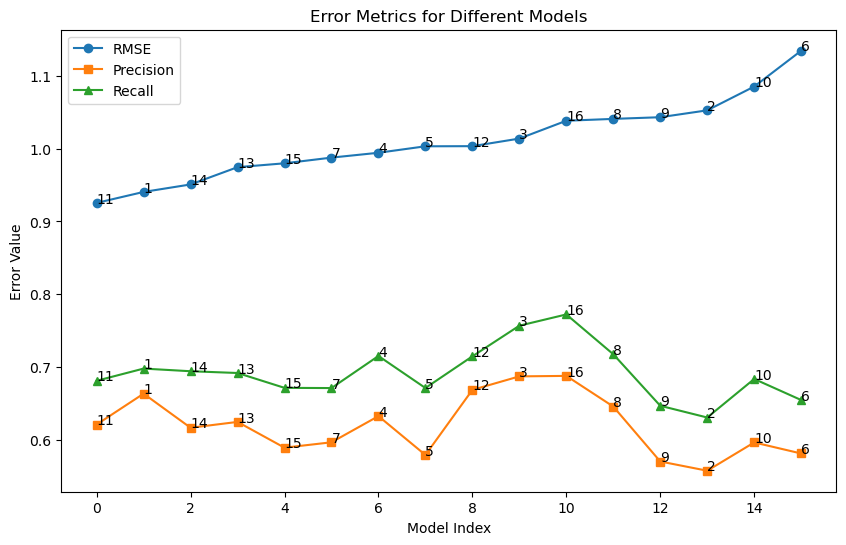

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

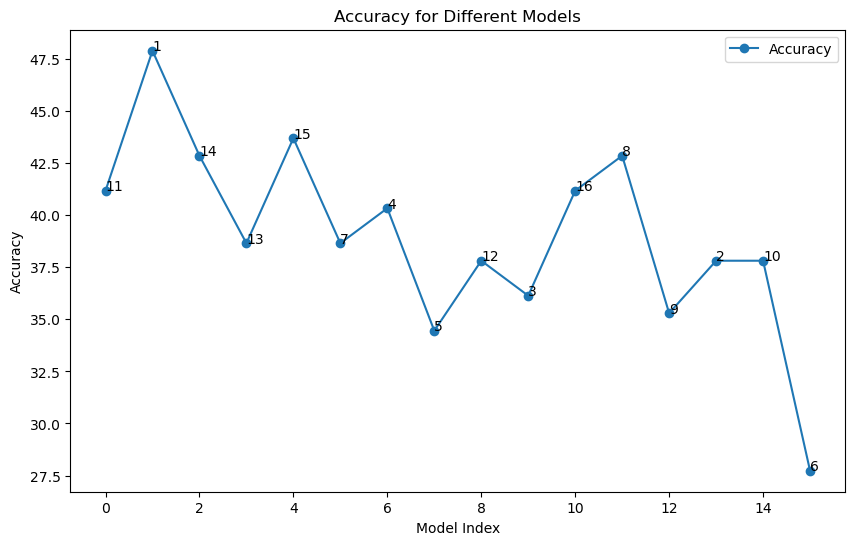

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_zscore.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Beaune 1er cru 'Clos les Aigrots'
2. Item ID: Les Fossiles Riesling


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_zscore.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 518f9753-12b1-4987-b651-38944fc33d07
2. User ID: 902db46c-a5bf-4d52-acd6-067a2bf3b876
3. User ID: 918cd9b7-8057-4106-8f7f-9e9e3a423fb1


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_zscore.get_neighbors_uid(user_id=5)

['e786582d-0deb-4e55-969e-065508ca1138',
 '36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 '5ccd8030-047b-432c-a630-d784ab415756',
 '976ec198-048f-405c-b6e6-b17ee1db1139',
 '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7',
 'f9b653da-6c1b-4390-87c6-f74e42bf0a03',
 'dc90e649-113d-4cec-983e-d03a7d4acff3',
 '91cf68cc-9436-43e1-871d-33beef4d2337',
 'ecc462e1-5041-43ca-94c3-c2bfc9b3215e',
 '41375cb6-321d-410a-bd0b-d0afed9f0417']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_zscore.get_neighbors_iid(item_id=20)

['Pinot Noir',
 'Pinot Grigio',
 'Vertigo',
 'Maikammer Kirchenstück',
 'Nebbiolo d alba superiore',
 'Quintessence Montagny 1er Cru',
 'Odessa Black',
 'Vinho Verde Branco',
 'Cabernet Sauvignon',
 'Domaine des Cassiers Pouilly-Fumé']

In [28]:
knn_with_zscore.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_zscore.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 21 with sim 0.000000000000000
And the baseline estimate is: 3.214605682291703

#####

Note: If the baseline is 3.6535433070866143 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_zscore.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,91cf68cc-9436-43e1-871d-33beef4d2337,Alsace Josmeyer Gewurztraminer Biodynamic,4.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",15,1,0.341207
1,3da6eec4-bd99-4370-be23-676baf750f19,Napa Valley Fumé Blanc,4.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.341207
2,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Perlé,5.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",7,1,1.341207
3,be0e69e3-30d5-4e21-b62f-05402fbfcd5a,Piceno Bacchus,5.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",2,0,1.341207
4,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Merlot,3.0,4.333333,"{'actual_k': 0, 'was_impossible': False}",6,4,1.333333
5,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Vieilles Vignes Rouge,5.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",11,0,1.341207
6,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Troj,4.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",11,0,0.341207
7,2ae69fac-d491-412f-8164-ccaf59a230c2,Ronco del Balbo Merlot,4.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",5,3,1.000000
8,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Beaune 1er cru 'Clos les Aigrots',5.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",12,0,1.341207
9,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",15,1,1.658793


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
60,776b5af7-bb8a-484a-bddb-dadf5dab4621,Muscat de Beaumes-de-Venise,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",3,2,0.000000
87,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Franciacorta,4.0,4.000000,"{'actual_k': 5, 'was_impossible': False}",6,2,0.000000
16,13016d41-00bd-411c-83f5-2b95691696b7,Malvasia legno,4.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",11,2,0.000000
56,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Brunello di Montalcino Riserva Vigna Paganelli,4.0,4.013309,"{'actual_k': 5, 'was_impossible': False}",6,2,0.013309
47,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Cabernet Franc,3.0,2.750000,"{'actual_k': 0, 'was_impossible': False}",11,2,0.250000
88,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Sauvignon,4.0,4.333333,"{'actual_k': 0, 'was_impossible': False}",6,3,0.333333
72,a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8,Classique,4.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",9,0,0.341207
69,ec237d07-aabf-47af-a3fa-2b60019d49d7,Barbera,4.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",4,1,0.341207
66,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Les Fossiles Riesling,4.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",12,0,0.341207
62,d7fffb49-a1f3-433c-a556-a3bc015e7e0f,La Rosina Barbera d'Alba Superiore,4.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",2,0,0.341207


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
9,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",15,1,1.658793
30,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Petite arvine nuance,2.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",11,0,1.658793
63,876b7023-bbf0-4bd8-a341-61ae5bc4b38f,Signoria Prosecco Extra Dry,2.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",2,1,1.658793
67,918cd9b7-8057-4106-8f7f-9e9e3a423fb1,Chardonnay,5.0,3.333333,"{'actual_k': 0, 'was_impossible': False}",1,6,1.666667
41,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Bollicina,5.0,3.166667,"{'actual_k': 0, 'was_impossible': False}",6,7,1.833333
91,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 11,1.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",13,1,2.658793
52,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",2,1,2.658793
97,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.658793
59,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,3.658793,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.658793
31,014e4ed1-6f8b-4b25-917d-c167a2acca17,New Wine,4.0,1.000000,"{'actual_k': 1, 'was_impossible': False}",1,3,3.000000
